In [1]:
# Google BQ connector
from google.cloud import bigquery

# Data processing libraries
import pandas as pd
import numpy as np

# Data visualisation tools
import matplotlib.pyplot as plt
from IPython.display import clear_output

# scikit learn
from sklearn.cluster import KMeans, DBSCAN

# pickle
import pickle

# IPython display
from IPython.display import clear_output

In [2]:
# creating a BQ client
bqclient = bigquery.Client()

In [4]:
query = """
SELECT
  rounded_lat, rounded_lng, COUNT(trj_id) as count_trip
FROM 
  (SELECT
    trj_id,
    ROUND(rawlat, 2) AS rounded_lat,
    ROUND(rawlng, 2) AS rounded_lng,
  FROM
    `jjkoh.grab_raw_singapore`)
GROUP BY
  rounded_lat, rounded_lng, trj_id
ORDER BY
  count_trip DESC
"""

In [5]:
df = bqclient.query(query).result().to_dataframe()

In [6]:
df.head()

,rounded_lat,rounded_lng,count_trip
0,1.44,103.77,1964
1,1.41,103.78,1476
2,1.34,103.81,1365
3,1.36,103.75,1306
4,1.37,103.84,1129


In [9]:
df.to_pickle("traffic-cluster-density.pkl")

In [2]:
df = pd.read_pickle("traffic-cluster-density.pkl")

In [4]:
X = df[['rounded_lat', 'rounded_lng']]
weights = df.count_trip

In [5]:
# calculate distortion for a range of number of cluster
max_nclusters = 32
distortions = [0]*max_nclusters
for i in range(1, max_nclusters):
    print('Calculating distortion with number of cluster {0}/{1}'.format(i, max_nclusters))
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=2020
    )
    km.fit(X, sample_weight=weights)
    distortions[i] = km.inertia_
    clear_output()

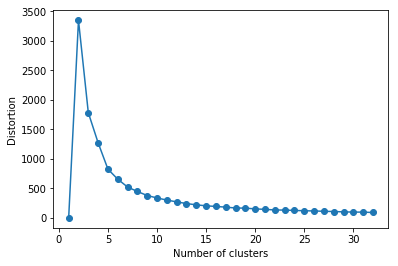

In [6]:
# plot
plt.plot(range(1, max_nclusters + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=20, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=2020)
kmeans.fit(X, sample_weight=weights)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2020, tol=0.0001, verbose=0)

In [8]:
# save kmeans-cluster pickle
with open("models/traffic-cluster-density-{0}-kmeans.pkl".format(20), "wb") as pkl:
    pickle.dump(kmeans, pkl)

In [9]:
# use cluster_count = 20
with open("models/traffic-cluster-density-{0}-kmeans.pkl".format(20), "rb") as pkl:
    kmeans = pickle.load(pkl)

In [10]:
df["cluster"] = kmeans.predict(df[["rounded_lat", "rounded_lng"]].values)

In [11]:
centers = kmeans.cluster_centers_

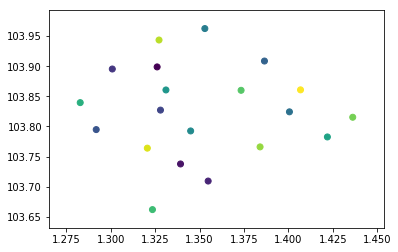

In [12]:
plt.scatter(centers[:, 0], centers[:, 1], c=range(20))

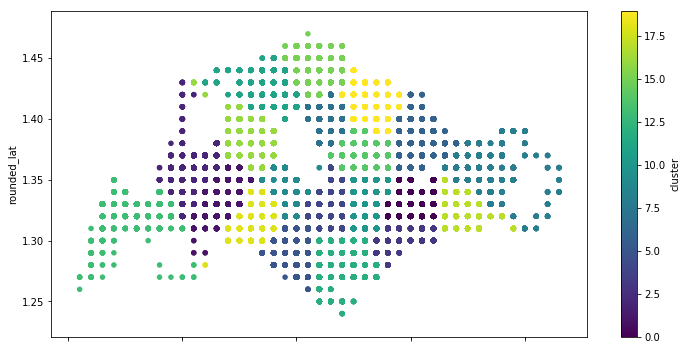

In [13]:
df.plot.scatter(x="rounded_lng", y="rounded_lat", c="cluster", figsize=(12, 6), colormap='viridis')

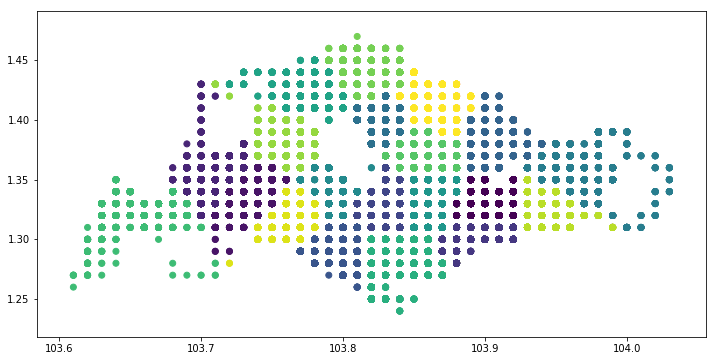

In [14]:
plt.figure(figsize=(12, 6))
plt.scatter(df.rounded_lng, df.rounded_lat, c=df.cluster)